## Libraries

In [35]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Loading Files & Data Exploration

In [36]:
import csv

trainingSet = pd.read_csv("./sample_data/train.csv")
testingSet = pd.read_csv("./sample_data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print("Training Set:")
print(trainingSet.head(5))
print()
print("Testing Set:")
print(testingSet.head(5))

train.csv shape is  (370703, 24)
test.csv shape is  (92676, 23)

Training Set:
        id                         trans_num  trans_date trans_time  \
0   308467  26ad750c2ff71f32631b58913582d70a  2024-01-10   06:49:39   
1   261578  fea9c1efe3f2b97f27ad0ab5409ec861  2024-01-06   02:37:50   
2      341  2ae350b982be840f3666273e0c2f3a05  2024-01-18   21:40:21   
3  1147639  bbdd8adfc0a34ed0e817f809193c85c0  2024-01-21   16:20:15   
4   314152  fc7756004dc2a9bc450eb894a670b804  2024-01-21   19:36:26   

    unix_time        category     amt            cc_num    first     last  \
0  1704887379        misc_pos  188.38      676355457570   Andrea  Johnson   
1  1704526670     grocery_pos  102.63   377178373574671   Rhonda   Chavez   
2  1705632021   entertainment    1.62  3599292013370451  Stephen     Khan   
3  1705872015  health_fitness    5.64  3594292572430345   Justin   Reilly   
4  1705883786  health_fitness   97.09  4867547663675548    Alice   Duarte   

   ...    zip      lat      lon

Index(['id', 'trans_num', 'trans_date', 'trans_time', 'unix_time', 'category',
       'amt', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'merchant', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

No Frauds 88.59 % of the dataset
Frauds 11.41 % of the dataset



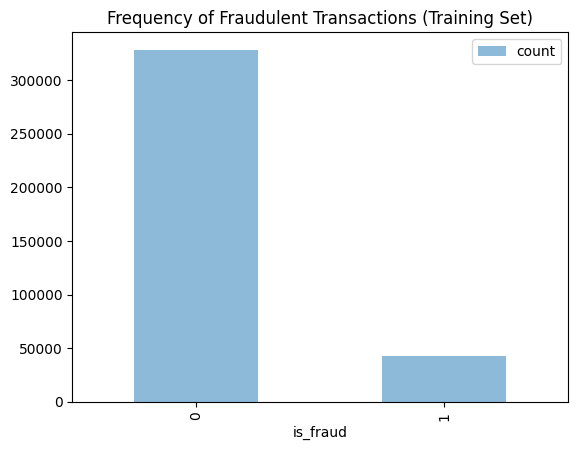

In [37]:
print(trainingSet.columns)
print()

print('No Frauds', round(trainingSet['is_fraud'].value_counts()[0]/len(trainingSet) * 100,2), '% of the dataset')
print('Frauds', round(trainingSet['is_fraud'].value_counts()[1]/len(trainingSet) * 100,2), '% of the dataset')
print()

trainingSet['is_fraud'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Frequency of Fraudulent Transactions (Training Set)")
plt.show()

In [38]:
trainingSet.isnull().sum().max()

0

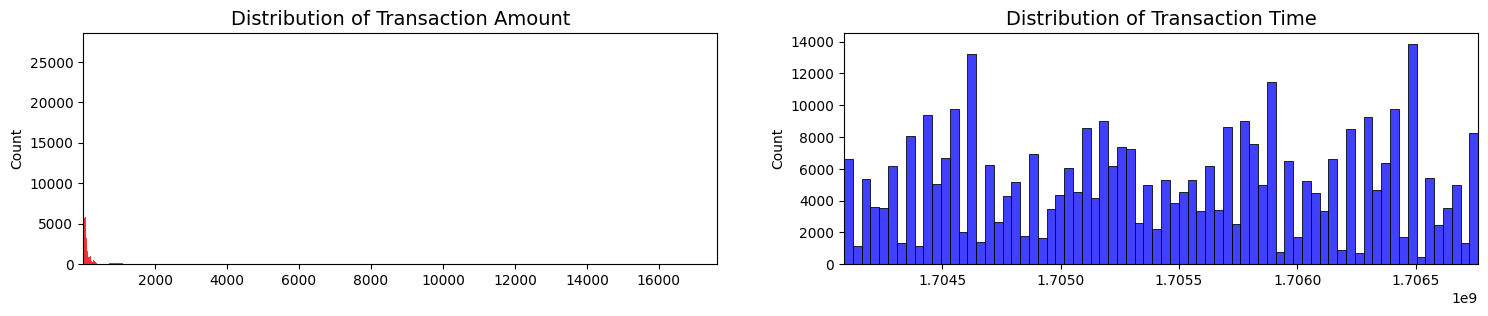

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(18,3))

amount_val = trainingSet['amt'].values
time_val = trainingSet['unix_time'].values

sns.histplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.histplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])


plt.show()

In [40]:
print("Min. Transaction Amount: ", trainingSet['amt'].values.min())
print("Max. Transaction Amount: ", trainingSet['amt'].values.max())
print("Mean of Transaction Amount: ", trainingSet['amt'].values.mean())
print("Standard Deviation of Transaction Amount: ", trainingSet['amt'].values.std())

Min. Transaction Amount:  1.0
Max. Transaction Amount:  17620.83
Mean of Transaction Amount:  123.49935770684345
Standard Deviation of Transaction Amount:  244.8128630158982


# Data Preprocessing

In [41]:
df = trainingSet.copy()
df.head()

,id,trans_num,trans_date,trans_time,unix_time,category,amt,cc_num,first,last,...,zip,lat,long,city_pop,job,dob,merchant,merch_lat,merch_long,is_fraud
0,308467,26ad750c2ff71f32631b58913582d70a,2024-01-10,06:49:39,1704887379,misc_pos,188.38,676355457570,Andrea,Johnson,...,62220,38.5127,-89.9847,95666,Accounting technician,1983-05-26,fraud_Turcotte-Halvorson,39.268874,-89.273447,0
1,261578,fea9c1efe3f2b97f27ad0ab5409ec861,2024-01-06,02:37:50,1704526670,grocery_pos,102.63,377178373574671,Rhonda,Chavez,...,21784,39.4567,-76.9696,37941,"Designer, graphic",1976-12-03,fraud_Schamberger-O'Keefe,39.961495,-76.707640,0
2,341,2ae350b982be840f3666273e0c2f3a05,2024-01-18,21:40:21,1705632021,entertainment,1.62,3599292013370451,Stephen,Khan,...,49735,45.0125,-84.6723,19515,Careers information officer,1999-08-24,"fraud_Nicolas, Hills and McGlynn",44.393561,-85.342323,0
3,1147639,bbdd8adfc0a34ed0e817f809193c85c0,2024-01-21,16:20:15,1705872015,health_fitness,5.64,3594292572430345,Justin,Reilly,...,44256,41.1404,-81.8584,62039,"Merchandiser, retail",1930-02-24,fraud_Cormier LLC,40.283764,-81.639361,0
4,314152,fc7756004dc2a9bc450eb894a670b804,2024-01-21,19:36:26,1705883786,health_fitness,97.09,4867547663675548,Alice,Duarte,...,91501,34.1862,-118.3009,106841,Prison officer,1951-10-15,fraud_Kulas Group,35.149704,-118.087440,0


Because we have a large standard deviation from the mean transaction amount of 123, with large outliers such as 17620, a RobustScaler will minimize the effect of outliers while still scaling the data appropriately.

In [42]:
from sklearn.preprocessing import StandardScaler, RobustScaler

rob_scaler = RobustScaler()

df['scaled_amt'] = rob_scaler.fit_transform(df['amt'].values.reshape(-1,1))
testingSet['scaled_amt'] = rob_scaler.transform(testingSet['amt'].values.reshape(-1,1))

df.drop(['amt'], axis=1, inplace=True)
testingSet.drop(['amt'], axis=1, inplace=True)

print("Min. Transaction Amount: ", df['scaled_amt'].values.min())
print("Max. Transaction Amount: ", df['scaled_amt'].values.max())
print("Mean of Transaction Amount: ", df['scaled_amt'].values.mean())
print("Standard Deviation of Transaction Amount: ", df['scaled_amt'].values.std())

Min. Transaction Amount:  -0.545367412140575
Max. Transaction Amount:  187.0992545260916
Mean of Transaction Amount:  0.7592050873998241
Standard Deviation of Transaction Amount:  2.6071657403184045


In [43]:
! pip install haversine

Feature engineering: Drop and modify columns

In [44]:
from haversine import haversine

columns_to_drop = ['trans_num', 'cc_num', 'first', 'last', 'street',
                   'city', 'state', 'zip', 'unix_time', 'job', 'gender']

df = df.drop(columns=columns_to_drop)
testingSet = testingSet.drop(columns=columns_to_drop)

# Create an age column to sort by instead of having unique dob
df['age'] = pd.to_datetime('today').year - pd.to_datetime(df['dob']).dt.year
df.drop(['dob'], axis=1, inplace=True)

testingSet['age'] = pd.to_datetime('today').year - pd.to_datetime(testingSet['dob']).dt.year
testingSet.drop(['dob'], axis=1, inplace=True)

# Combine distance metrics into one comprehensive column
df['distance_from_merchant'] = df.apply(
    lambda row: haversine((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])),
    axis=1)
df.drop(['lat', 'long', 'merch_lat', 'merch_long'], axis=1, inplace=True)

testingSet['distance_from_merchant'] = testingSet.apply(
    lambda row: haversine((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])),
    axis=1)
testingSet.drop(['lat', 'long', 'merch_lat', 'merch_long'], axis=1, inplace=True)

print(df.columns)

Index(['id', 'trans_date', 'trans_time', 'category', 'city_pop', 'merchant',
       'is_fraud', 'scaled_amt', 'age', 'distance_from_merchant'],
      dtype='object')


Handle categorical values

In [45]:
from sklearn.preprocessing import LabelEncoder
categorical_cols = ['trans_date', 'trans_time', 'category', 'city_pop', 'merchant']

for col in categorical_cols:
  print(f"{col}: {df[col].nunique()}")

trans_date: 31
trans_time: 84303
category: 14
city_pop: 5889
merchant: 693


In [46]:
df['hour'] = pd.to_datetime(df['trans_time']).dt.hour  # Extract hour of day
df['minute_group'] = (pd.to_datetime(df['trans_time']).dt.minute // 15)  # 15-minute intervals
df['time_period'] = pd.cut(df['hour'], bins=[-1, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

df['day_of_week'] = pd.to_datetime(df['trans_date']).dt.weekday  # 0 = Monday, 6 = Sunday
df['week_of_year'] = pd.to_datetime(df['trans_date']).dt.isocalendar().week  # ISO week number
df['week_of_year'] = df['week_of_year'].astype('int32')
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['day_of_month'] = pd.to_datetime(df['trans_date']).dt.day


testingSet['hour'] = pd.to_datetime(testingSet['trans_time']).dt.hour  # Extract hour of day
testingSet['minute_group'] = (pd.to_datetime(testingSet['trans_time']).dt.minute // 15)  # 15-minute intervals
testingSet['time_period'] = pd.cut(testingSet['hour'], bins=[-1, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

testingSet['day_of_week'] = pd.to_datetime(testingSet['trans_date']).dt.weekday  # 0 = Monday, 6 = Sunday
testingSet['week_of_year'] = pd.to_datetime(testingSet['trans_date']).dt.isocalendar().week  # ISO week number
testingSet['week_of_year'] = testingSet['week_of_year'].astype('int32')
testingSet['is_weekend'] = testingSet['day_of_week'].isin([5, 6]).astype(int)
testingSet['day_of_month'] = pd.to_datetime(testingSet['trans_date']).dt.day

<ipython-input-46-f2680b7d304a>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hour'] = pd.to_datetime(df['trans_time']).dt.hour  # Extract hour of day
<ipython-input-46-f2680b7d304a>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['minute_group'] = (pd.to_datetime(df['trans_time']).dt.minute // 15)  # 15-minute intervals
<ipython-input-46-f2680b7d304a>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  testingSet['hour'] = pd.to_datetime(testingSet['trans_time']).dt.hour  # Extract hour of day
<ipython-input-46-f2680b7d304a>:13: UserWarning: Could not infer format

In [47]:
# fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# # Plot 1: Distribution of Hour of Day
# sns.histplot(df['hour'], bins=24, kde=False, color='blue', ax=axes[0, 0])
# axes[0, 0].set_title("Transaction Distribution by Hour of Day", fontsize=14)
# axes[0, 0].set_xlabel("Hour of Day")
# axes[0, 0].set_ylabel("Frequency")
# axes[0, 0].set_xticks(range(0, 24))
# axes[0, 0].grid(axis='y')

# # Plot 2: Transactions by Time Period
# sns.countplot(x='time_period', data=df, palette='coolwarm', ax=axes[0, 1])
# axes[0, 1].set_title("Transactions by Time Period", fontsize=14)
# axes[0, 1].set_xlabel("Time Period")
# axes[0, 1].set_ylabel("Count")

# # Plot 3: Day of Week Distribution
# sns.countplot(x='day_of_week', data=df, palette='viridis', ax=axes[1, 0])
# axes[1, 0].set_title("Transactions by Day of the Week", fontsize=14)
# axes[1, 0].set_xlabel("Day of Week (0=Monday, 6=Sunday)")
# axes[1, 0].set_ylabel("Frequency")
# axes[1, 0].grid(axis='y')

# # Plot 4: Transactions: Weekday vs. Weekend
# sns.countplot(x='is_weekend', data=df, palette='pastel', ax=axes[1, 1])
# axes[1, 1].set_title("Transactions: Weekday vs. Weekend", fontsize=14)
# axes[1, 1].set_xlabel("Is Weekend (0=Weekday, 1=Weekend)")
# axes[1, 1].set_ylabel("Count")
# axes[1, 1].set_xticks([0, 1])
# axes[1, 1].set_xticklabels(['Weekday', 'Weekend'])
# axes[1, 1].grid(axis='y')

# # Plot 5: Transactions by Week of the Year
# sns.histplot(df['week_of_year'], bins=52, kde=False, color='green', ax=axes[2, 0])
# axes[2, 0].set_title("Transaction Distribution by Week of the Year", fontsize=14)
# axes[2, 0].set_xlabel("Week of Year")
# axes[2, 0].set_ylabel("Frequency")
# axes[2, 0].grid(axis='y')

# # Plot 6: Day of Month Distribution
# sns.histplot(df['day_of_month'], bins=31, kde=False, color='purple', ax=axes[2, 1])
# axes[2, 1].set_title("Transaction Distribution by Day of the Month", fontsize=14)
# axes[2, 1].set_xlabel("Day of Month")
# axes[2, 1].set_ylabel("Frequency")
# axes[2, 1].grid(axis='y')

# plt.tight_layout()
# plt.show()

In [48]:
df.drop(['trans_date'], axis=1, inplace=True)
df.drop(['trans_time'], axis=1, inplace=True)

testingSet.drop(['trans_date'], axis=1, inplace=True)
testingSet.drop(['trans_time'], axis=1, inplace=True)

In [49]:
from sklearn.preprocessing import OneHotEncoder

df_to_encode = df[['category', 'time_period']]

encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df_to_encode)

one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['category', 'time_period']))

df = df.drop(['category', 'time_period'], axis=1)
df = pd.concat([df, one_hot_encoded_df], axis=1)

testingSet_to_encode = testingSet[['category', 'time_period']]

one_hot_encoded = encoder.transform(testingSet_to_encode)
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['category', 'time_period']))

testingSet = testingSet.drop(['category', 'time_period'], axis=1)
testingSet = pd.concat([testingSet, one_hot_encoded_df], axis=1)

In [50]:
df.head()

,id,city_pop,merchant,is_fraud,scaled_amt,age,distance_from_merchant,hour,minute_group,day_of_week,...,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,time_period_Afternoon,time_period_Evening,time_period_Morning,time_period_Night
0,308467,95666,fraud_Turcotte-Halvorson,0,1.450160,41,104.206874,6,3,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,261578,37941,fraud_Schamberger-O'Keefe,0,0.536954,48,60.438349,2,2,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,341,19515,"fraud_Nicolas, Hills and McGlynn",0,-0.538765,25,86.836718,21,2,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1147639,62039,fraud_Cormier LLC,0,-0.495953,94,97.026218,16,1,6,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,314152,106841,fraud_Kulas Group,0,0.477955,73,108.900835,19,2,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Label Encoding (Tree-based Models)

In [51]:
# label_encoder = LabelEncoder()

# df['merchant_encoded'] = label_encoder.fit_transform(df['merchant'])
# df = df.drop('merchant', axis=1)

Frequency Encoding (Tree-based Models)

In [52]:
merchant_counts = df['merchant'].value_counts()
df['merchant_encoded'] = df['merchant'].map(merchant_counts)

df = df.drop('merchant', axis=1)

merchant_counts = testingSet['merchant'].value_counts()
testingSet['merchant_encoded'] = testingSet['merchant'].map(merchant_counts)

testingSet = testingSet.drop('merchant', axis=1)

Target Encoding (Linear Models)

In [53]:
# merchant_target_encoding = df.groupby('merchant')['is_fraud'].mean()
# df['merchant_encoded'] = df['merchant'].map(merchant_target_encoding)

# df = df.drop('merchant', axis=1)

Train Test Split

In [54]:
from sklearn.model_selection import train_test_split

X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Training set: (296562, 30), Test set: (74141, 30)


Do a Stratified K-Fold Cross Validation to ensure the same proportion of fraud and non-fraud samples across fields

In [55]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy=0.4, random_state=42)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [56]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# Apply SMOTE
# oversampler = SMOTE(random_state=42)
# X_train, y_train = oversampler.fit_resample(X_train, y_train)

# Apply SMOTEENN
# hybrid_sampler = SMOTEENN(random_state=42)
# X_train, y_train = hybrid_sampler.fit_resample(X_train, y_train)


In [57]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

f1_scores = []

for train_idx, val_idx in skf.split(X_train, y_train):
    # Split data into training and validation
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    y_train_fold = y_train_fold.astype(int)

    # Convert to NumPy for compatibility
    X_train_fold = X_train_fold.to_numpy()
    y_train_fold = y_train_fold.to_numpy()

    # Apply SMOTEENN only on the training fold
    # smoteenn = SMOTEENN(random_state=42)
    # X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train_fold, y_train_fold)

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)

    # Train the model
    # model = XGBClassifier(
    #     objective='binary:logistic',
    #     eval_metric='auc',
    #     use_label_encoder=False,
    #     n_estimators=100,
    #     learning_rate=0.1,
    #     max_depth=6,
    #     scale_pos_weight=len(y_train_resampled) / (2 * sum(y_train_resampled == 1)),
    # )
    # model.fit(X_train_resampled, y_train_resampled)
    xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        scale_pos_weight=len(y_train_resampled) / (2 * sum(y_train_resampled == 1)),
    )
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    lgbm = LGBMClassifier(n_estimators=100, random_state=42)

    # ensemble = VotingClassifier(
    #     estimators=[('xgb', xgb), ('rf', rf), ('lgbm', lgbm)],
    #     voting='soft'
    # )

    # ensemble.fit(X_train_resampled, y_train_resampled)

    stacking_ensemble = StackingClassifier(
      estimators=[('xgb', xgb), ('rf', rf), ('lgbm', lgbm)],
      final_estimator=LogisticRegression(),
      cv=5
    )

    # Train the stacking ensemble
    stacking_ensemble.fit(X_train_resampled, y_train_resampled)

    # Evaluate on validation/test set
    y_val_pred = stacking_ensemble.predict(X_val_fold)
    f1 = f1_score(y_val_fold, y_val_pred)
    print(f"F1 Score on Validation Fold: {f1:.4f}")

    f1_scores.append(f1)

print(f"Mean F1 Score across folds: {sum(f1_scores) / len(f1_scores):.4f}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:48:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 67677, number of negative: 67677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7629
[LightGBM] [Info] Number of data points in the train set: 135354, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:49:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:49:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:49:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:49:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:49:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Number of positive: 54142, number of negative: 54141
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7638
[LightGBM] [Info] Number of data points in the train set: 108283, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Info] Number of positive: 54142, number of negative: 54141
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7637
[LightGBM] [Info] Number of data points in the train set: 108283, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[Li

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:52:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 67677, number of negative: 67677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7630
[LightGBM] [Info] Number of data points in the train set: 135354, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:53:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:53:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:53:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:53:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:53:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Number of positive: 54142, number of negative: 54141
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7639
[LightGBM] [Info] Number of data points in the train set: 108283, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Info] Number of positive: 54142, number of negative: 54141
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7640
[LightGBM] [Info] Number of data points in the train set: 108283, number of used features: 30
[LightGBM] [Info] 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:56:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 67678, number of negative: 67678
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7631
[LightGBM] [Info] Number of data points in the train set: 135356, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:56:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:56:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:56:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:57:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:57:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Number of positive: 54142, number of negative: 54142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7639
[LightGBM] [Info] Number of data points in the train set: 108284, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 54143, number of negative: 54142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7639
[LightGBM] [Info] Number of data points in the train set: 108285, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:00:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 67678, number of negative: 67678
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7629
[LightGBM] [Info] Number of data points in the train set: 135356, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:00:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:00:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:00:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:00:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:00:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Number of positive: 54142, number of negative: 54142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7637
[LightGBM] [Info] Number of data points in the train set: 108284, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 54143, number of negative: 54142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7637
[LightGBM] [Info] Number of data points in the train set: 108285, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:03:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 67678, number of negative: 67678
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7629
[LightGBM] [Info] Number of data points in the train set: 135356, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:04:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:04:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:04:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:04:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:04:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Number of positive: 54142, number of negative: 54142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7638
[LightGBM] [Info] Number of data points in the train set: 108284, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 54143, number of negative: 54142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7639
[LightGBM] [Info] Number of data points in the train set: 108285, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0

In [58]:
# Check class distribution in Train-Test Split
print("\nOverall class distribution:")
print(y.value_counts(normalize=True))

print("\nTraining set class distribution:")
y_train_resampled = pd.Series(y_train_resampled).astype(int)
print(y_train_resampled.value_counts(normalize=True))

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))


Overall class distribution:
is_fraud
0    0.885895
1    0.114105
Name: proportion, dtype: float64

Training set class distribution:
0    0.5
1    0.5
Name: proportion, dtype: float64

Test set class distribution:
is_fraud
0    0.885893
1    0.114107
Name: proportion, dtype: float64


Logistic Regression

In [59]:
# from sklearn.linear_model import LogisticRegression

# logreg = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
# logreg.fit(X_train, y_train)

# y_pred = logreg.predict(X_test)

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

# sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
# plt.title('Confusion matrix of the classifier')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# print("Accuracy on testing set = ", accuracy_score(y_test, y_pred))

Gradient Boosted is more accurate than Logistic Regression

Gradient Boosted Trees

In [60]:
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Ensure y_train is integer type
y_train = y_train.astype(int)

# Apply SMOTEENN
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Convert X_train_resampled back to DataFrame, if necessary
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)

# Convert y_train_resampled to integer type
y_train_resampled = pd.Series(y_train_resampled).astype(int)

# Train final model
xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        scale_pos_weight=len(y_train_resampled) / (2 * sum(y_train_resampled == 1)),
    )
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, random_state=42)

stacking_ensemble = StackingClassifier(
  estimators=[('xgb', xgb), ('rf', rf), ('lgbm', lgbm)],
  final_estimator=LogisticRegression(),
  cv=5
)

stacking_ensemble.fit(X_train_resampled, y_train_resampled)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:07:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 67678, number of negative: 67678
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7629
[LightGBM] [Info] Number of data points in the train set: 135356, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:07:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:07:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:07:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:07:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:07:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Number of positive: 54142, number of negative: 54142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7638
[LightGBM] [Info] Number of data points in the train set: 108284, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 54143, number of negative: 54142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7639
[LightGBM] [Info] Number of data points in the train set: 108285, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              lea...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('lgbm', LGBMClassifier(random_state=42))],
                   final_estimator=LogisticRegression())

In [61]:
# Predict probabilities
y_pred_proba = stacking_ensemble.predict_proba(X_test)[:, 1]

# Evaluate Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[f1_scores.argmax()]
print(f"Optimal threshold: {optimal_threshold:.4f}")

# Use optimal threshold for final predictions
final_predictions = (y_pred_proba >= optimal_threshold).astype(int)

# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(y_test, final_predictions))
print("Classification Report:")
print(classification_report(y_test, final_predictions))

print("\nF1 on testing set = ", f1_score(y_test, final_predictions))

Optimal threshold: 0.9613
Confusion Matrix:
[[65592    89]
 [  389  8071]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     65681
           1       0.99      0.95      0.97      8460

    accuracy                           0.99     74141
   macro avg       0.99      0.98      0.98     74141
weighted avg       0.99      0.99      0.99     74141


F1 on testing set =  0.9712394705174489


Now do threshold tuning and precision-recall curve evaluation

In [62]:
# from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, classification_report
# import matplotlib.pyplot as plt

# # Train the model (assuming you've already done this)
# # model.fit(X_train, y_train)

# # Predict probabilities
# y_pred_proba = model.predict_proba(X_test)[:, 1]

# # Evaluate Precision-Recall Curve
# precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# # Calculate F1 scores for each threshold from the precision-recall curve
# f1_scores = 2 * (precision * recall) / (precision + recall)

# # Get the optimal threshold based on the F1 score from precision-recall curve
# optimal_threshold = thresholds[f1_scores.argmax()]
# print(f"Optimal threshold based on precision-recall curve: {optimal_threshold}")

# # Use the optimal threshold for final predictions
# final_predictions = (y_pred_proba >= optimal_threshold).astype(int)

# # Confusion Matrix with optimal threshold
# print("Confusion Matrix (after threshold tuning):")
# print(confusion_matrix(y_test, final_predictions))

# # Classification report with optimal threshold
# print(classification_report(y_test, final_predictions))

# # Plot Precision-Recall Curve (optional)
# plt.plot(recall, precision, marker='.')
# plt.title('Precision-Recall Curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.show()

In [63]:
testingSet.shape

(92676, 30)

In [64]:
# testingSet['is_fraud'] = model.predict(testingSet)
testingSet['is_fraud'] = (stacking_ensemble.predict_proba(testingSet)[:, 1] >= optimal_threshold).astype(int)
testingSet.head()

,id,city_pop,scaled_amt,age,distance_from_merchant,hour,minute_group,day_of_week,week_of_year,is_weekend,...,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,time_period_Afternoon,time_period_Evening,time_period_Morning,time_period_Night,merchant_encoded,is_fraud
0,52329,2504700,-0.417572,69,10.771882,13,1,5,4,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,174,0
1,92215,419138,-0.282961,84,46.299842,21,0,2,5,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,59,0
2,107070,4953,0.503408,31,59.548018,23,0,2,4,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,155,0
3,117508,2846,9.798190,66,122.505876,14,2,0,3,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,215,1
4,525132,13835,1.201597,52,58.554446,22,0,1,5,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,139,0


Create submission file

In [65]:
submission = testingSet[['id', 'is_fraud']]
submission.to_csv("./sample_data/submission.csv", index=False)
print("Number of rows:", submission.shape[0])

Number of rows: 92676


In [66]:
submission.head()

,id,is_fraud
0,52329,0
1,92215,0
2,107070,0
3,117508,1
4,525132,0


In [67]:
# Check the distribution of 0s and 1s in the 'is_fraud' column
value_counts = submission['is_fraud'].value_counts()
print(value_counts)

is_fraud
0    82383
1    10293
Name: count, dtype: int64
